In [1]:
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import matplotlib.pyplot as plt
import seaborn as sns
import umap

/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packag

In [2]:
# load custom collection of functions
import sys
sys.path.append('/home/schmiedc/FMP_Docs/Projects/Bioactives_data/notebooks/')
import utility_functions as UTIL

In [3]:
parent_directory = "/home/schmiedc/FMP_Docs/Projects/Bioactives_data/"

input_path = parent_directory + "results/"
output_path = input_path

figure_path = parent_directory + "figures/"

annot_path = parent_directory  + "annotations/"

# UMAP 

Settings:

n_neighbors = 30

min_dist = 0.1

In [4]:
def draw_umap(data,
              features,
              metadata,
              cell_type, 
              n_neighbors=15, 
              min_dist=0.1, 
              n_components=2, 
              metric='euclidean',
              title='',
              filename = ''):
    
    # function is a UMAP
    axis_1 = "UMAP_Axis_1"
    axis_2 = "UMAP_Axis_2"
    
    # plot params
    marker_color = ["lightgray", "purple"]
    marker_edgecolor = "none"
    marker_size = 15
    marker_alpha = 0.6
    
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    
    u = fit.fit_transform(features);

    u_dataframe = pd.DataFrame(data = u,
                               columns = [axis_1, 
                                          axis_2])

    # Get EOS annotation back
    u_dataframe_annot = pd.merge(data.loc[:, metadata], 
                                  u_dataframe, 
                                  left_index = True, 
                                  right_index = True)

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
    fig.suptitle(title, fontsize=18)
    
    sns.scatterplot(
        data = u_dataframe_annot,
        x=axis_1,
        y=axis_2,
        hue = 'Metadata_' + cell_type + '_inactive',
        palette = ["lightgray", "navy"],
        edgecolor = marker_edgecolor,
        s = marker_size,
        alpha = marker_alpha,
        ax=axs[0, 0]
    )

    sns.scatterplot(
        data = u_dataframe_annot,
        x=axis_1,
        y=axis_2,
        hue = 'Metadata_' + cell_type + '_Toxic',
        palette = ["lightgray", "purple"],
        edgecolor = marker_edgecolor,
        s = marker_size,
        alpha = marker_alpha,
        ax=axs[0, 1]
    )

    sns.scatterplot(
        data = u_dataframe_annot,
        x=axis_1,
        y=axis_2,
        hue = 'Metadata_tubulin',
        palette = ["lightgray", "darkgreen"],
        edgecolor = marker_edgecolor,
        s = marker_size,
        alpha = marker_alpha,
        ax=axs[0, 2]
    )

    sns.scatterplot(
        data = u_dataframe_annot,
        x=axis_1,
        y=axis_2,
        hue = 'Metadata_DMSO',
        palette = marker_color,
        edgecolor = marker_edgecolor,
        s = marker_size,
        alpha = marker_alpha,
        ax=axs[1, 0]
    )

    sns.scatterplot(
        data = u_dataframe_annot,
        x=axis_1,
        y=axis_2,
        hue = 'Metadata_Nocodazole',
        palette = marker_color,
        edgecolor = marker_edgecolor,
        s = marker_size,
        alpha = marker_alpha,
        ax=axs[1, 1]
    )

    sns.scatterplot(
        data = u_dataframe_annot,
        x=axis_1,
        y=axis_2,
        hue = 'Metadata_Tetrandrine',
        palette = marker_color,
        edgecolor = marker_edgecolor,
        s = marker_size,
        alpha = marker_alpha,
        ax=axs[1, 2]
    )
    
    plt.savefig(filename)  

# Load and process annotations

In [5]:
annotation_compounds = pd.read_csv(annot_path + "pd_export_04_2022_2464_compounds_standardized.csv")
annotation_compounds.columns = annotation_compounds.columns.str.replace(' ', '_')
annotation_compounds = annotation_compounds.add_prefix('Metadata_')

In [6]:
annotation_targets = pd.read_csv(annot_path + 'pd_export_04_2022_2464_targets_standardized.csv')
annotation_targets.columns = annotation_targets.columns.str.replace(' ', '_')
annotation_targets = annotation_targets.add_prefix('Metadata_')
annotation_targets.shape

(29915, 31)

In [7]:
id_file = pd.read_csv(annot_path + "2024-08-02_EOS_pdid.csv")
id_file.shape

(2464, 2)

In [8]:
annotation_tubulin = pd.read_csv(annot_path + "2024-08-02_Tubulin.csv")
annotation_tubulin.shape

(2464, 2)

In [9]:
# get EUOS number 
annotation_compounds = pd.merge(annotation_compounds,
                     annotation_tubulin,
                     on = ["Metadata_pdid"],
                     how = "left",
                     indicator = False)

In [10]:
# get EUOS number 
annotation_compounds_2 = pd.merge(annotation_compounds,
                     id_file,
                     on = ["Metadata_pdid"],
                     how = "left",
                     indicator = False)

# U2 OS

## Load Normalized data

In [11]:
# Load normalized data
file_U2OS_type = '/*[0-9]_' + 'FMP_U2OS_norm.csv'
files_U2OS = glob.glob(input_path + file_U2OS_type)

### gets latest file
max_file_U2OS = max(files_U2OS, key=os.path.getctime)

### load file
data_U2OS_Norm = pd.read_csv(max_file_U2OS)
data_U2OS_Norm.shape

(10629, 2984)

In [12]:
# Feature reduction
print("Feature reduction with correlation threshold 0.9 and Outlier threshold 100")
U2OS_Reduced_Carsten_100_Mod = UTIL.feature_reduction(data_U2OS_Norm, 
                                         variance_freq_cut=0.1, 
                                         variance_unique_cut=0.1, 
                                         outlier_cutoff=100, 
                                         corr_threshold = 0.9, 
                                         print_stats = True)

Feature reduction with correlation threshold 0.9 and Outlier threshold 100
| Category           |   Original Features |   Variance Threshold |   % Variance |   Outlier Threshold |   % Outlier |   Correlation Threshold |   % Correlation |
|:-------------------|--------------------:|---------------------:|-------------:|--------------------:|------------:|------------------------:|----------------:|
| Total Features     |                2977 |                 2803 |         94.2 |                2071 |        69.6 |                     738 |            24.8 |
| Intensity          |                 180 |                  180 |        100   |                 125 |        69.4 |                      44 |            24.4 |
| Correlation        |                 180 |                  122 |         67.8 |                  99 |        55   |                      68 |            37.8 |
| AreaShape          |                 162 |                  155 |         95.7 |                 149 |      

## Remove non reproducible compounds

In [13]:
# Load non replicating compounds
file_U2OS_nonreplicating_type = '/*[0-9]_' + 'FMP_U2OS_non-replicating.csv'
files_U2OS_nonreplicating = glob.glob(input_path + file_U2OS_nonreplicating_type)

### gets latest file
max_files_U2OS_nonreplicating = max(files_U2OS_nonreplicating, key=os.path.getctime)

### load file
data_U2OS_nonreplicating = pd.read_csv(max_files_U2OS_nonreplicating)
data_U2OS_nonreplicating.shape

(261, 1)

In [14]:
# Get replicating compound by removing non replicating compounds
FMP_U2OS_Data_replicating = U2OS_Reduced_Carsten_100_Mod.loc[~U2OS_Reduced_Carsten_100_Mod["Metadata_EOS"].isin(data_U2OS_nonreplicating["Metadata_EOS"])].copy()
FMP_U2OS_Data_replicating.shape

(9586, 745)

## Get low active compounds

In [15]:
# Load low active compounds
file_U2OS_inactive_type = '/*[0-9]_' + 'FMP_U2OS_low-active.csv'
files_U2OS_inactive = glob.glob(input_path + file_U2OS_inactive_type)

### gets latest file
max_file_U2OS_inactive = max(files_U2OS_inactive, key=os.path.getctime)

### load file
data_U2OS_inactive = pd.read_csv(max_file_U2OS_inactive)
data_U2OS_inactive.shape

(690, 1)

In [16]:
data_U2OS_inactive_annot = pd.merge(data_U2OS_inactive,
                               id_file,
                               on = ["Metadata_EOS"],
                               how = "left",
                               indicator = True)

In [17]:
annotation_compounds_2['Metadata_U2OS_inactive'] = annotation_compounds_2['Metadata_pdid'].isin(data_U2OS_inactive_annot['Metadata_pdid'])

## Get toxic compounds

In [19]:
# data_U2OS_Median = pd.read_csv(input_path + "2023-04-11_Bioactives_U2OS_norm_reduced_filtered_median.csv")
file_U2OS_tox_type = '/*[0-9]_' + 'FMP_U2OS_toxic_all.csv'
files_U2OS_tox = glob.glob(input_path + file_U2OS_tox_type)

### gets latest file
max_file_U2OS_tox = max(files_U2OS_tox, key=os.path.getctime)

### load file
data_U2OS_tox = pd.read_csv(max_file_U2OS_tox)
data_U2OS_tox.shape

(177, 1)

In [20]:
data_U2OS_tox_annot = pd.merge(data_U2OS_tox,
                               id_file,
                               on = ["Metadata_EOS"],
                               how = "left",
                               indicator = True)

In [21]:
annotation_compounds_2['Metadata_U2OS_Toxic'] = annotation_compounds_2['Metadata_pdid'].isin(data_U2OS_tox_annot['Metadata_pdid'])

## Process for visualization

In [22]:
## gets feature vector
Features_U2OS_Norm_Reduced = UTIL.get_feature_vector(FMP_U2OS_Data_replicating)

# Compute consensus
Features_U2OS_Norm_Reduced_Median = pycytominer.consensus(
        profiles = FMP_U2OS_Data_replicating, # A file or pandas DataFrame of profile data
        replicate_columns = ["Metadata_EOS", "Metadata_Plate", "Metadata_Concentration", "Metadata_Partner"], # Metadata columns indicating which replicates to collapse, defaults to [“Metadata_Plate”, “Metadata_Well”]
        operation = "median", # (str) – The method used to form consensus profiles, defaults to “median”
        features = Features_U2OS_Norm_Reduced, # (str, list) – The features to collapse, defaults to “infer”
)

In [23]:
U2OS_Norm_Reduced_Median_annot = pd.merge(Features_U2OS_Norm_Reduced_Median,
                                              annotation_compounds_2,
                                              how = 'left',
                                              on=['Metadata_EOS'])

In [24]:
U2OS_Norm_Reduced_Median_annot['Metadata_Nocodazole'] = U2OS_Norm_Reduced_Median_annot['Metadata_EOS'].str.contains('Nocodazole', case=False, na=False)
U2OS_Norm_Reduced_Median_annot['Metadata_Tetrandrine'] = U2OS_Norm_Reduced_Median_annot['Metadata_EOS'].str.contains('Tetrandrine', case=False, na=False)
U2OS_Norm_Reduced_Median_annot['Metadata_DMSO'] = U2OS_Norm_Reduced_Median_annot['Metadata_EOS'].str.contains('DMSO', case=False, na=False)

In [25]:
# Data without metadata columns
FMP_U2OS_Data = U2OS_Norm_Reduced_Median_annot.reset_index(drop = True)
FMP_U2OS_Features = UTIL.get_feature_vector(FMP_U2OS_Data)
FMP_U2OS_Meta_Features = list(set(FMP_U2OS_Data.columns) - set(FMP_U2OS_Features ))
    

FMP_U2OS_x = FMP_U2OS_Data.loc[:, FMP_U2OS_Features]

In [26]:
# change table data formats for specific columns
FMP_U2OS_Data['Metadata_tubulin'].fillna(False,inplace=True)
FMP_U2OS_Data['Metadata_U2OS_Toxic'].fillna(False,inplace=True)
FMP_U2OS_Data['Metadata_U2OS_inactive'].fillna(False,inplace=True)

## Visualize with UMAP

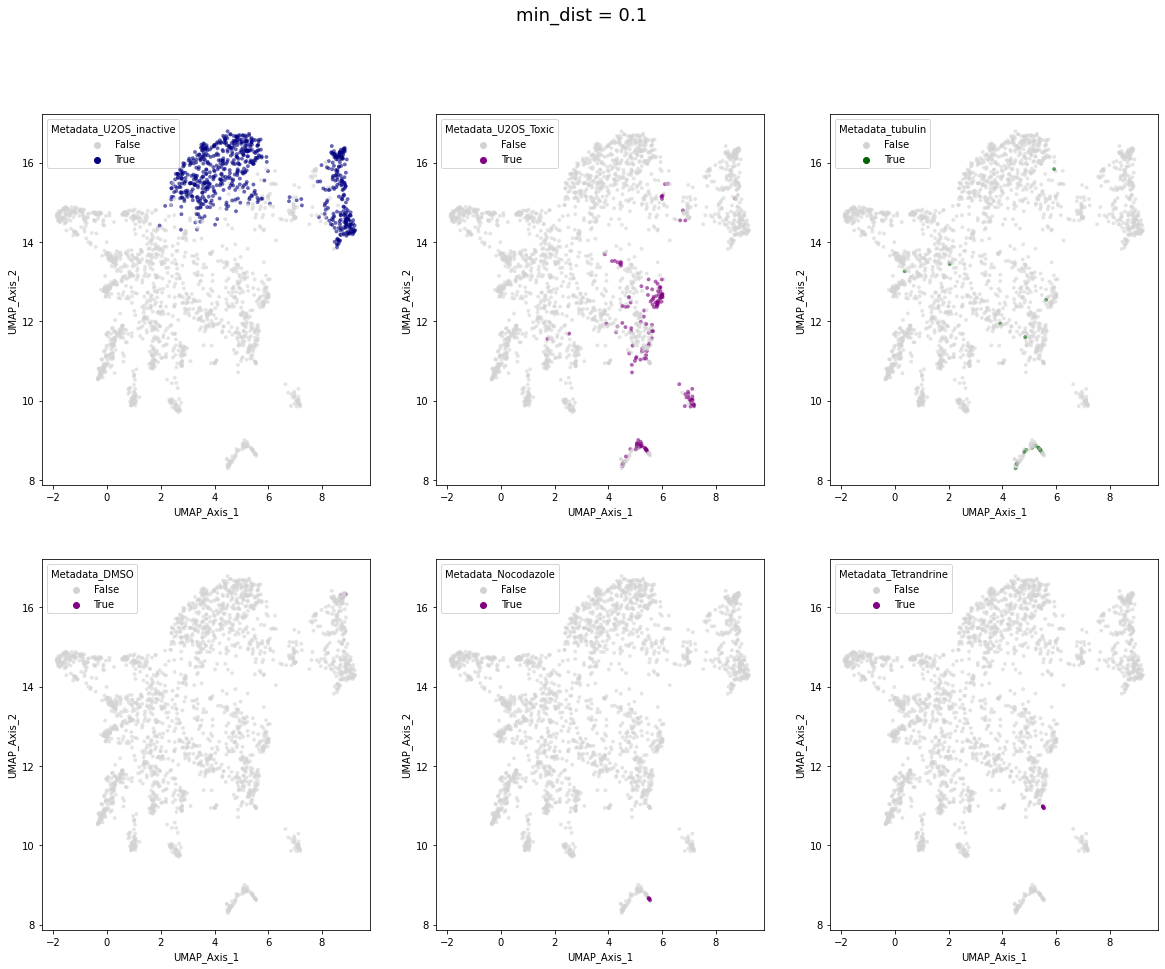

In [27]:
filename_U2OS_UMAP = figure_path + str(date.today()) + "_FMP_U2OS_UMAP_2D_VizOnly.pdf"

draw_umap(data = FMP_U2OS_Data,
          features = FMP_U2OS_x,
          metadata = FMP_U2OS_Meta_Features,
          cell_type='U2OS',
          n_neighbors=30,
          min_dist=0.1,
          title='min_dist = {}'.format(0.1),
          filename = filename_U2OS_UMAP)

# HepG2

## Normalized data

In [28]:
# Load normalized data
file_HepG2_type = '/*[0-9]_' + 'FMP_HepG2_norm.csv'
files_HepG2 = glob.glob(input_path + file_HepG2_type)

### gets latest file
max_file_HepG2 = max(files_HepG2, key=os.path.getctime)

### load file
data_HepG2_Norm = pd.read_csv(max_file_HepG2)
data_HepG2_Norm.shape

(10697, 2984)

In [29]:
# HepG2 feature reduction
print("Feature reduction with correlation threshold 0.9 and Outlier threshold 100")
HepG2_Reduced_Carsten_100_Mod = UTIL.feature_reduction(data_HepG2_Norm, 
                                         variance_freq_cut=0.1, 
                                         variance_unique_cut=0.1, 
                                         outlier_cutoff=100, 
                                         corr_threshold = 0.9, 
                                         print_stats = True)

Feature reduction with correlation threshold 0.9 and Outlier threshold 100
| Category           |   Original Features |   Variance Threshold |   % Variance |   Outlier Threshold |   % Outlier |   Correlation Threshold |   % Correlation |
|:-------------------|--------------------:|---------------------:|-------------:|--------------------:|------------:|------------------------:|----------------:|
| Total Features     |                2977 |                 2811 |         94.4 |                2177 |        73.1 |                     654 |            22   |
| Intensity          |                 180 |                  180 |        100   |                 149 |        82.8 |                      44 |            24.4 |
| Correlation        |                 180 |                  120 |         66.7 |                  99 |        55   |                      65 |            36.1 |
| AreaShape          |                 162 |                  154 |         95.1 |                 139 |      

## Remove non reproducible compounds

In [30]:
# data_HepG2_Norm = pd.read_csv(input_path + "2023-04-11_Bioactives_HepG2_norm.csv")
file_HepG2_nonreplicating_type = '/*[0-9]_' + 'FMP_HepG2_non-replicating.csv'
files_HepG2_nonreplicating = glob.glob(input_path + file_HepG2_nonreplicating_type)

### gets latest file
max_files_HepG2_nonreplicating = max(files_HepG2_nonreplicating, key=os.path.getctime)

### load file
data_HepG2_nonreplicating = pd.read_csv(max_files_HepG2_nonreplicating)
data_HepG2_nonreplicating.shape

(72, 1)

In [31]:
FMP_HepG2_Data_replicating = HepG2_Reduced_Carsten_100_Mod.loc[~HepG2_Reduced_Carsten_100_Mod["Metadata_EOS"].isin(data_HepG2_nonreplicating["Metadata_EOS"])].copy()
FMP_HepG2_Data_replicating.shape

(10409, 661)

## Get toxic compounds

In [32]:
# data_U2OS_Median = pd.read_csv(input_path + "2023-04-11_Bioactives_U2OS_norm_reduced_filtered_median.csv")
file_HepG2_tox_type = '/*[0-9]_' + 'FMP_HepG2_toxic_all.csv'
files_HepG2_tox = glob.glob(input_path + file_HepG2_tox_type)

### gets latest file
max_file_HepG2_tox = max(files_HepG2_tox, key=os.path.getctime)

### load file
data_HepG2_tox = pd.read_csv(max_file_HepG2_tox)
data_HepG2_tox.shape

(103, 1)

In [33]:
data_HepG2_tox_annot = pd.merge(data_HepG2_tox,
                               id_file,
                               on = ["Metadata_EOS"],
                               how = "left",
                               indicator = True)

In [34]:
annotation_compounds_2['Metadata_HepG2_Toxic'] = annotation_compounds_2['Metadata_pdid'].isin(data_HepG2_tox_annot['Metadata_pdid'])

## Get low active compounds

In [35]:
file_HepG2_inactive_type = '/*[0-9]_' + 'FMP_HepG2_low-active.csv'
files_HepG2_inactive = glob.glob(input_path + file_HepG2_inactive_type)

### gets latest file
max_file_HepG2_inactive = max(files_HepG2_inactive, key=os.path.getctime)

### load file
data_HepG2_inactive = pd.read_csv(max_file_HepG2_inactive)
data_HepG2_inactive.shape

(1503, 1)

In [36]:
data_HepG2_inactive_annot = pd.merge(data_HepG2_inactive,
                               id_file,
                               on = ["Metadata_EOS"],
                               how = "left",
                               indicator = True)

In [37]:
annotation_compounds_2['Metadata_HepG2_inactive'] = annotation_compounds_2['Metadata_pdid'].isin(data_HepG2_inactive_annot['Metadata_pdid'])

## Process for visualization

In [38]:
## gets feature vector
Features_HepG2_Norm_Reduced = UTIL.get_feature_vector(FMP_HepG2_Data_replicating)

Features_HepG2_Norm_Reduced_Median = pycytominer.consensus(
        profiles = FMP_HepG2_Data_replicating, # A file or pandas DataFrame of profile data
        replicate_columns = ["Metadata_EOS", "Metadata_Plate", "Metadata_Concentration", "Metadata_Partner"], # Metadata columns indicating which replicates to collapse, defaults to [“Metadata_Plate”, “Metadata_Well”]
        operation = "median", # (str) – The method used to form consensus profiles, defaults to “median”
        features = Features_HepG2_Norm_Reduced, # (str, list) – The features to collapse, defaults to “infer”
)

In [39]:
HepG2_Norm_Reduced_Median_annot = pd.merge(Features_HepG2_Norm_Reduced_Median,
                                              id_file,
                                              how = 'left',
                                              on=['Metadata_EOS'])

In [40]:
HepG2_Norm_Reduced_Median_annot2 = pd.merge(HepG2_Norm_Reduced_Median_annot,
                                              annotation_compounds_2,
                                              how = 'left',
                                              on=['Metadata_EOS'])

In [41]:
HepG2_Norm_Reduced_Median_annot2['Metadata_Nocodazole'] = HepG2_Norm_Reduced_Median_annot2['Metadata_EOS'].str.contains('Nocodazole', case=False, na=False)
HepG2_Norm_Reduced_Median_annot2['Metadata_Tetrandrine'] = HepG2_Norm_Reduced_Median_annot2['Metadata_EOS'].str.contains('Tetrandrine', case=False, na=False)
HepG2_Norm_Reduced_Median_annot2['Metadata_DMSO'] = HepG2_Norm_Reduced_Median_annot2['Metadata_EOS'].str.contains('DMSO', case=False, na=False)

In [42]:
# Data without metadata columns
FMP_HepG2_Data = HepG2_Norm_Reduced_Median_annot2.reset_index(drop = True)
FMP_HepG2_Features = UTIL.get_feature_vector(FMP_HepG2_Data)
FMP_HepG2_Meta_Features = list(set(FMP_HepG2_Data.columns) - set(FMP_HepG2_Features ))
    
FMP_HepG2_x = FMP_HepG2_Data.loc[:, FMP_HepG2_Features]

In [43]:
FMP_HepG2_Data['Metadata_tubulin'].fillna(False,inplace=True)
FMP_HepG2_Data['Metadata_HepG2_Toxic'].fillna(False,inplace=True)
FMP_HepG2_Data['Metadata_HepG2_inactive'].fillna(False,inplace=True)

## Visualization with UMAP

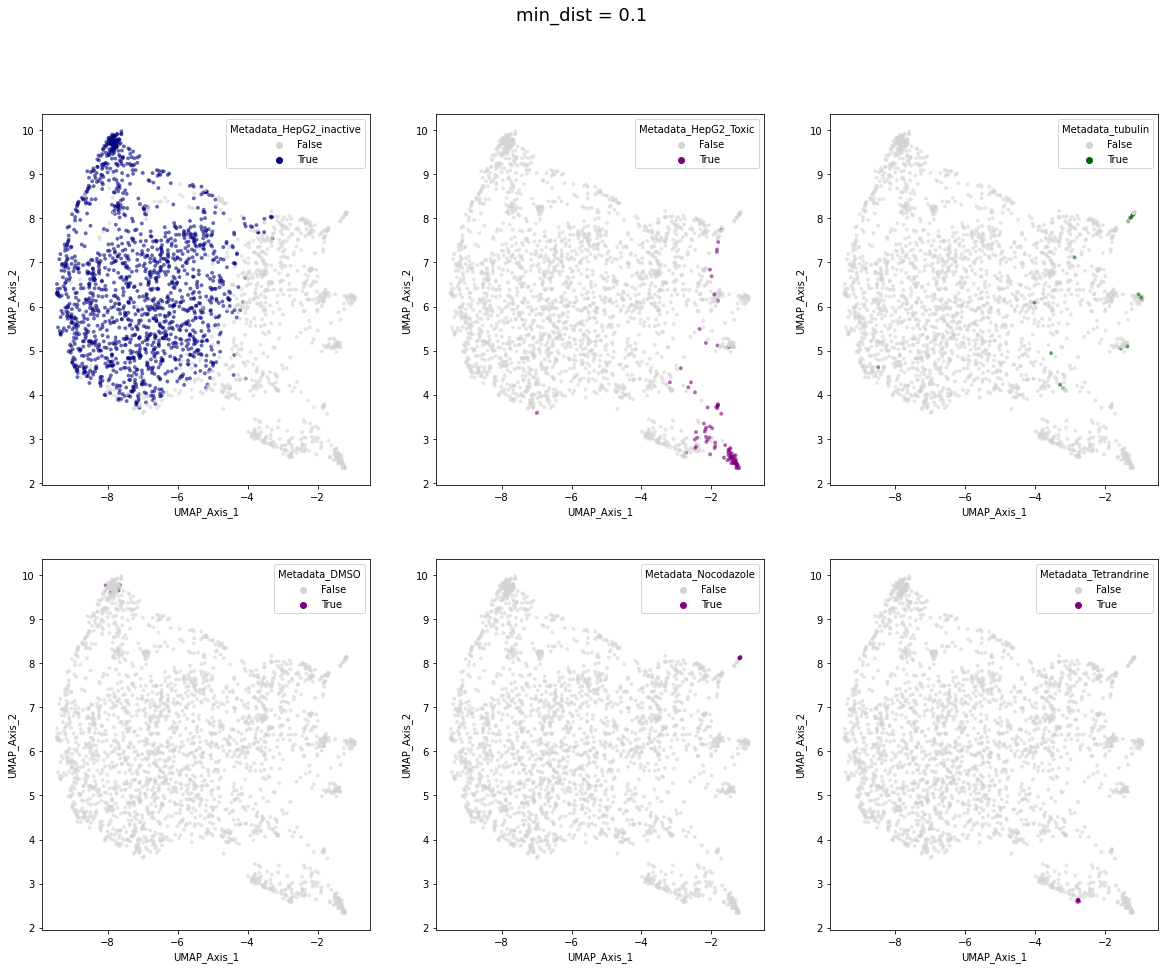

In [44]:
filename_HepG2_UMAP = figure_path + str(date.today()) + "_FMP_HepG2_UMAP_2D_VizOnly.pdf"

draw_umap(data = FMP_HepG2_Data,
          features = FMP_HepG2_x,
          metadata = FMP_HepG2_Meta_Features,
          cell_type='HepG2',
          n_neighbors=30,
          min_dist=0.1,
          title='min_dist = {}'.format(0.1),
          filename = filename_HepG2_UMAP)

# Number and precent toxic, low active

## Toxic

In [45]:
# precent toxic all U2OS
number_all = len(annotation_compounds_2)

number_toxic = len(annotation_compounds_2[
    annotation_compounds_2['Metadata_U2OS_Toxic']])

print('Precent toxic all cpds in U2 OS: ', ( number_toxic / number_all ) * 100 )

Precent toxic all cpds in U2 OS:  7.142857142857142


In [46]:
# precent toxic all HepG2
number_all = len(annotation_compounds_2)

number_toxic = len(annotation_compounds_2[
    annotation_compounds_2['Metadata_HepG2_Toxic']])

print('Precent toxic all cpds in Hep G2: ', ( number_toxic / number_all ) * 100 )

Precent toxic all cpds in Hep G2:  4.180194805194805


## Activity

In [47]:
# precent toxic all U2OS
number_all = len(annotation_compounds_2)

number_inactive = len(annotation_compounds_2[
    annotation_compounds_2['Metadata_U2OS_inactive']])

print('Precent inactive cpds in U2 OS: ', ( number_inactive / number_all ) * 100 )

Precent inactive cpds in U2 OS:  27.962662337662337


In [48]:
# precent toxic all U2OS
number_all = len(annotation_compounds_2)

number_inactive = len(annotation_compounds_2[
    annotation_compounds_2['Metadata_HepG2_inactive']])

print('Precent inactive cpds in Hep G2: ', ( number_inactive / number_all ) * 100 )

Precent inactive cpds in Hep G2:  60.9577922077922
